In [1]:
import sys
sys.path.append("..")   # add the root project folder to the system path variable
from schuberts_leader.core_components import simulate_leading_indicator_data, leading_indicator_miner
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pprint import pprint

Simulate some data for us to use:

( documentation is available using `help(simulate_leading_indicator_data)` )

In [5]:
sim_explain_dict, y_arr, X_arr = simulate_leading_indicator_data(
        n_time_points = 1_000
    ,   n_predictors = 50
    ,   n_leading_indicator_effects = 10
    ,   lagged_effect_time_min_max = (1,10)
    ,   polynomial_coefs_min_max = (
        (-1,1),
        (-0.01,0.01), #(-0.002,0.002),
        (-0.0001,0.0001), #(-0.00002,0.00002),
    )
)
X_varnames = [f"X_{i}" for i in range(X_arr.shape[1])]

Have a look at a (random) few of the simulated leading relationships:

In [ ]:
for k in np.random.choice(list(sim_explain_dict.keys()), size=5, replace=False):
    lag_i = sim_explain_dict[k][0]["lag"]
    plt.figure( figsize=(10,5) )
    plt.scatter( X_arr[:(len(X_arr)-lag_i),k], y_arr[lag_i:] )
    plt.xlabel( f"x[{k}],[t]" )
    plt.ylabel( f"y[t+{lag_i}]" )

split the data into a training and a test partition:

In [6]:
test_percent = 0.1
train_idx = ( 0, int((1-test_percent)*len(y_arr))-1 ) 
test_idx = (train_idx[1]+1, len(y_arr))
train_y_arr = y_arr[train_idx[0]:train_idx[1]+1] 
test_y_arr = y_arr[test_idx[0]:test_idx[1]] 
train_X_arr = X_arr[train_idx[0]:train_idx[1]+1,:] 
test_X_arr = X_arr[test_idx[0]:test_idx[1],:]

mine the data for training data for leading indicators:

In [7]:
leading_indicator_miner_model = leading_indicator_miner(n_leading_indicators=5)
leading_indicator_miner_model.fit(
    X = train_X_arr, 
    X_varnames = X_varnames, 
    y = train_y_arr, 
    y_varname = "y", 
    n_iterations = 1_000, 
    n_lags_to_consider = {'min': 1, 'max': 20}, 
    n_knots_to_consider = {'min': 10, 'max': 10}
)

iteration 1,000 of 1,000. best MSE: 20,678,292,277.408

Text(0.5, 1.0, 'Mean Squared Error on Training Data')

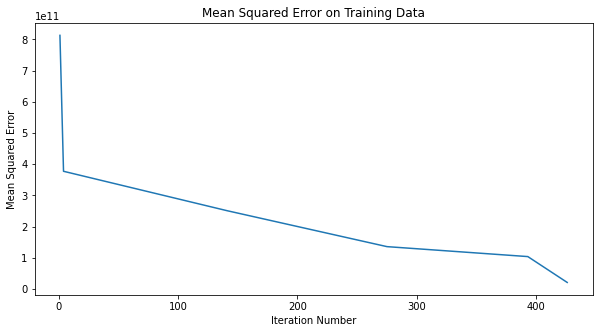

In [8]:
plt.figure( figsize=(10,5) )
plt.plot( 
    [x[0] for x in leading_indicator_miner_model.mse_history],
    [x[1] for x in leading_indicator_miner_model.mse_history],
)
plt.xlabel("Iteration Number")
plt.ylabel("Mean Squared Error")
plt.title("Mean Squared Error on Training Data")

visualize the leading indicators discovered:

In [ ]:
for x in leading_indicator_miner_model.best_leading_indicators_vars_set:
    lag_i = x["lag_n_time_periods"]
    #print(x)
    #plt.figure( figsize=(10,5) )
    #plt.scatter( train_X_arr[:(len(train_X_arr)-lag_i),x], train_y_arr[lag_i:] )
    #plt.xlabel( f"x[{x}],[t]" )
    #plt.ylabel( f"y[t+{lag_i}]" )

In [10]:
test_forecasts = leading_indicator_miner_model.predict(
    X = train_X_arr, 
    X_varnames = X_varnames
)
test_forecasts

array([[-9583179.03606181, -9758130.5319591 , -9355666.55174823,
        -9136664.46099442,               nan,               nan,
                      nan,               nan,               nan,
                      nan,               nan,               nan,
                      nan,               nan,               nan],
       [-8823419.64593712, -8931978.26332234,               nan,
                      nan,               nan,               nan,
                      nan,               nan,               nan,
                      nan,               nan,               nan,
                      nan,               nan,               nan],
       [-7734412.40782222, -7634901.68848797, -7567972.04426185,
        -7701233.97572594, -7727801.65954048, -7632905.71577297,
        -7684233.54410851,               nan,               nan,
                      nan,               nan,               nan,
                      nan,               nan,               nan],
       [-8572224.77547

# Random experiment with EWMA

In [ ]:
sim_n = 100
x_vec = np.random.uniform(low=-100, high=100, size=sim_n).cumsum()
y_vec = np.random.uniform(low=-100, high=100, size=sim_n).cumsum()
effect_lag = 3
a, b = -0.7, -0.05
y_vec += np.concatenate(
    [   np.zeros(effect_lag),
        a*(x_vec[:(len(x_vec)-effect_lag)]) + b*(x_vec[:(len(x_vec)-effect_lag)]**2)
    ]
)
for lag_l in range(1,5):
    plt.figure( figsize=(10,5) )
    plt.scatter(
            x_vec[:(len(x_vec)-lag_l)]
        ,   y_vec[lag_l:]
    )
    plt.xlabel(f"X[t]")
    plt.ylabel(f"Y[t+{lag_l}]")

def simple_exp_wt_mov_avg_np_arr_1D(np_arr, alpha):
    """
    calculates an exponentially weighted moving average version of a provided 1-Dimensional numpy array
    this implementation is designed for clarity rather than code optimality

    An exponentially weighted moving average of univariate time series variable X is defined as:
        ewma[t] = alpha*X[t] + (1-alpha)*ewma[t-1]

    Parameters
    ----------
    np_arr : np.array(), float
        a 1-Dimensional numpy array of float type
    alpha : float
        decay parameter - must be in the range (0,1)

    Returns
    ----------
    np.array(), float
        a 1-Dimensional numpy array of the same dimension as the input array [np_arr], containing the exponentially-weighted moving average
    """
    import numpy as np

    assert (
        len(np_arr.shape) == 1
    ), "np_arr must be 1-Dimensional (i.e. len(np_arr.shape)==1"
    assert alpha > 0 and alpha < 1, "must have 0 < alpha < 1"

    ewma_list = [np_arr[0]]
    for i in range(1, len(np_arr)):
        ewma_list.append(alpha * np_arr[i] + (1 - alpha) * ewma_list[-1])

    return np.array(ewma_list)

x_vec_ewma = simple_exp_wt_mov_avg_np_arr_1D(x_vec, alpha=0.5)
for lag_l in range(1,9):
    plt.figure( figsize=(10,5) )
    plt.scatter(
            x_vec_ewma[:(len(x_vec_ewma)-lag_l)]
        ,   y_vec[lag_l:]
    )
    plt.title("EWMA[0.5]")
    plt.xlabel(f"X[t]")
    plt.ylabel(f"Y[t+{lag_l}]")

plt.figure( figsize=(10,5) )
plt.plot(x_vec, label="x")
plt.plot(x_vec_ewma, label="x_ewma")
plt.legend()
